# AVO Explorer

Online interactive tool to build quick and dirty AVO models based on average elastic properties across an interface.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import bruges as b
%matplotlib inline

In [25]:
# values from Hilterman, class 3 gas sand
vp1,vs1,rho1=[2191,818,2.16]
vp2,vs2,rho2=[1542,901,1.88]

# values from Simm, p.17
vp1,vs1,rho1 = 2438, 1006, 2.25
vp2,vs2,rho2 = 2600, 1700, 1.85
ang = np.arange(0,70,1)

avo_shuey2 = b.reflection.shuey2(vp1,vs1,rho1,vp2,vs2,rho2,ang)
avo_shuey3 = b.reflection.shuey3(vp1,vs1,rho1,vp2,vs2,rho2,ang)
avo_hilt   = b.reflection.hilterman(vp1,vs1,rho1,vp2,vs2,rho2,ang)
avo_aki    = b.reflection.akirichards(vp1,vs1,rho1,vp2,vs2,rho2,ang)
avo_fatti  = b.reflection.fatti(vp1,vs1,rho1,vp2,vs2,rho2,ang)
avo_zoepp  = b.reflection.zoeppritz(vp1,vs1,rho1,vp2,vs2,rho2,ang)

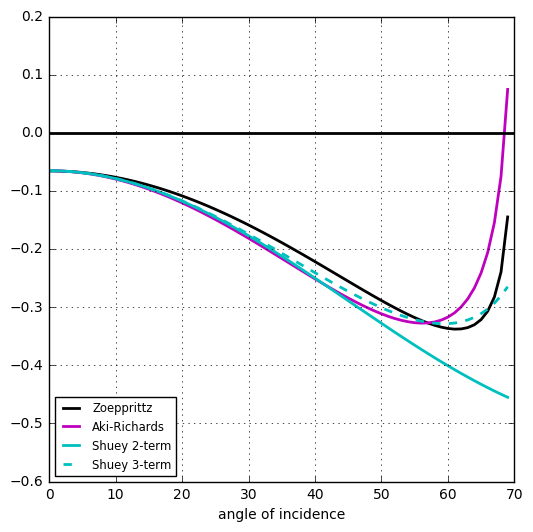

In [34]:
f,ax=plt.subplots(1,1, figsize=(6, 6))
ax.plot(ang, avo_zoepp,'-k',   lw=2, label='Zoepprittz')
ax.plot(ang, avo_aki,'-m',     lw=2, label='Aki-Richards')
ax.plot(ang, avo_shuey2,'-c',  lw=2, label='Shuey 2-term')
ax.plot(ang, avo_shuey3,'--c', lw=2, label='Shuey 3-term')
# ax.plot(ang, avo_hilt,'-b',    lw=2, label='Hilterman')
# ax.plot(ang, avo_fatti,'-g',   lw=2, label='Fatti')
ax.axhline(0, color='k', lw=2)
ax.set_xlabel('angle of incidence')
ax.set_ylim(-.6, .2)
ax.grid()
ax.legend(fontsize='small', loc='lower left')

Building the classic AVO reference charts:

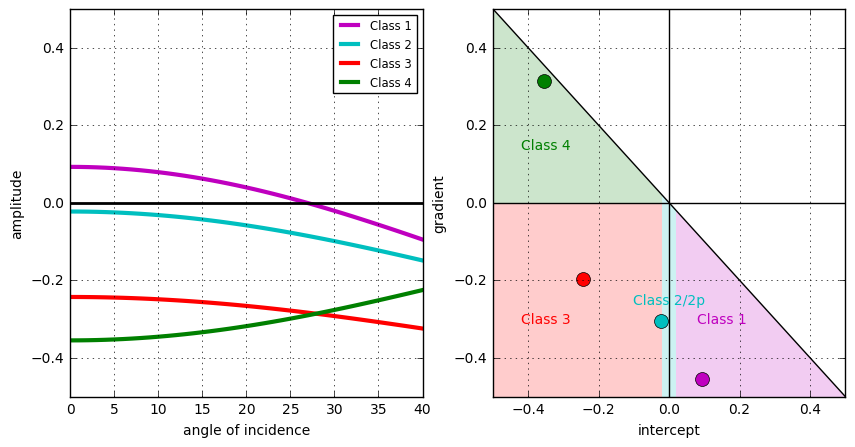

In [92]:
# AVO class 4
vp1,vs1,rho1 = 3024,1620,2.34
vp2,vs2,rho2 = 1650,1090,2.07
cl4 = b.reflection.shuey2(vp1, vs1, rho1, vp2, vs2, rho2, ang)
tmp = b.reflection.shuey2(vp1,vs1,rho1,vp2,vs2,rho2,30,terms=True)
Icl4 = tmp[0]
Gcl4 = tmp[1] / np.sin(np.radians(30))**2
    
# cl3
vp1,vs1,rho1 = 2191,818,2.16
vp2,vs2,rho2 = 1542,901,1.88
cl3 = b.reflection.shuey2(vp1, vs1, rho1, vp2, vs2, rho2, ang)
tmp = b.reflection.shuey2(vp1,vs1,rho1,vp2,vs2,rho2,30,terms=True)
Icl3 = tmp[0]
Gcl3 = tmp[1] / np.sin(np.radians(30))**2

# cl2
vp1,vs1,rho1 = 2643,1167,2.29
vp2,vs2,rho2 = 2781,1665,2.08
cl2 = b.reflection.shuey2(vp1, vs1, rho1, vp2, vs2, rho2, ang)
tmp = b.reflection.shuey2(vp1,vs1,rho1,vp2,vs2,rho2,30,terms=True)
Icl2 = tmp[0]
Gcl2 = tmp[1] / np.sin(np.radians(30))**2

# cl1
vp1,vs1,rho1 = 3094,1515,2.40
vp2,vs2,rho2 = 4050,2526,2.21
cl1 = b.reflection.shuey2(vp1, vs1, rho1, vp2, vs2, rho2, ang)
tmp = b.reflection.shuey2(vp1,vs1,rho1,vp2,vs2,rho2,30,terms=True)
Icl1 = tmp[0]
Gcl1 = tmp[1] / np.sin(np.radians(30))**2

import matplotlib.patches as patches
f,ax=plt.subplots(1,2, figsize=(10, 5))
ax[0].plot(ang, cl1,'-m', lw=3, label='Class 1')
ax[0].plot(ang, cl2,'-c', lw=3, label='Class 2')
ax[0].plot(ang, cl3,'-r', lw=3, label='Class 3')
ax[0].plot(ang, cl4,'-g', lw=3, label='Class 4')
ax[0].axhline(0, color='k', lw=2)
ax[0].set_xlabel('angle of incidence'), ax[0].set_ylabel('amplitude')
ax[0].set_ylim(-.5, .5), ax[0].set_xlim(0, 40)
ax[0].legend(fontsize='small', loc='upper right')
ax[1].plot(Icl1, Gcl1,'mo', ms=10, label='Class 1')
ax[1].plot(Icl2, Gcl2,'co', ms=10, label='Class 2')
ax[1].plot(Icl3, Gcl3,'ro', ms=10, label='Class 3')
ax[1].plot(Icl4, Gcl4,'go', ms=10, label='Class 4')
ax[1].axhline(0, color='k'), ax[1].axvline(0, color='k')
ax[1].set_xlabel('intercept'), ax[1].set_ylabel('gradient')
ax[1].set_ylim(-.5, .5), ax[1].set_xlim(-.5, .5)
#ax[1].set_ylim(-.2, .2), ax[1].set_xlim(-.2, .2)
for aa in ax:
    aa.grid()

# draw avo classes areas
cl1_area = patches.Rectangle((0.02,-1),.98,1,edgecolor='None',facecolor='m',alpha=0.2)
cl2_area = patches.Rectangle((-0.02,-1),.04,2,edgecolor='None',facecolor='c',alpha=0.2)
cl3_area = patches.Rectangle((-1,-1),.98,1,edgecolor='None',facecolor='r',alpha=0.2)
cl4_area = patches.Rectangle((-1,0),.98,1,edgecolor='None',facecolor='g',alpha=0.2)
background = patches.Polygon([[-1, 1], [1, -1], [1, 1]],facecolor='w')
ax[1].add_patch(cl1_area)
ax[1].add_patch(cl2_area)
ax[1].add_patch(cl3_area)
ax[1].add_patch(cl4_area)
ax[1].add_patch(background)
ax[1].text(.15,-.3,'Class 1',ha='center',va='center',color='m')
ax[1].text(0,-.25,'Class 2/2p',ha='center',va='center', color='c')
ax[1].text(-.35,-.3,'Class 3',ha='center',va='center', color='r')
ax[1].text(-.35,.15,'Class 4',ha='center',va='center', color='g')

Attempt to show the rotation of the background trend with increasing Vp/Vs ratio in the reservoir.

From: Castagna, J. P., and H. W. Swan, 1997, Principles of AVO crossplotting: The Leading Edge.

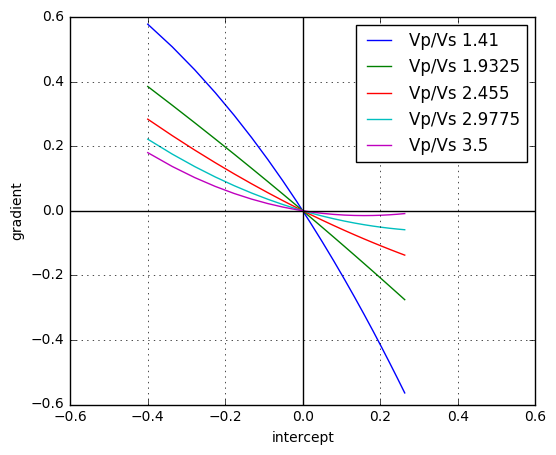

In [109]:
vp_sh,vs_sh=3500,1700

vp = np.linspace(1500,6000,20)
vpvs = np.linspace(1.41,3.5,5)
trendsA=np.zeros((vpvs.size,vp.size))
trendsB=np.zeros((vpvs.size,vp.size))

for i,vpvs_tmp in enumerate(vpvs):
    for j,vp_tmp in enumerate(vp):
        vs = vp_tmp/vpvs_tmp
        vp0 = (vp_sh+vp_tmp)/2
        vs0 = (vs_sh+vs)/2
        dvp=vp_tmp-vp_sh
    
        A = 0.5 * dvp/vp0
        B = A*(1-8*(vs0/vp0)**2)
#        A = 5/8 * dvp/vp0
#        B = 4/5*A*(1-9*(vs0/vp0)**2)

        trendsA[i,j]=A
        trendsB[i,j]=B
        

plt.figure(figsize=(6,5))
for i in range(vpvs.size):
    plt.plot(trendsA[i,:], trendsB[i,:], label='Vp/Vs '+str(vpvs[i]))
plt.legend()
plt.xlim(-.6,.6), plt.ylim(-.6,.6)
plt.axhline(0, color='k'), plt.axvline(0, color='k')
plt.xlabel('intercept'), plt.ylabel('gradient')
plt.grid()

    class1=find(Ig>0.02 & Gg<0)
    class2=find(Ig>0 & Ig<=.02 & Gg<0)
    class2p=find(Ig<0 & Ig>=-.02 & Gg<0)
    class3=find(Ig<-.02 & Gg<0)
    class4=find(Ig<-.02 & Gg>0)

In [15]:
def avoplotmod(vp1,vs1,rho1,vp2,vs2,rho2,angmin=0,angmax=30,name=None,polarity='normal',mx=0.5,method='shuey'):
    '''
    avoplotmod (C) aadm 2016
    AVO and Intercept-Gradient crossplots for a simple 2-layer model.

    INPUT
    vp1,vs1,rho1: elastic properties of upper layer, e.g. [2191,818,2.16]
    vp2,vs2,rho2: elastic properties of lower layer, e.g. [1542,901,1.88]
    angmin, angmax: minimum, maximum angle of incidence
    name: well name (or anything else) to print
    polarity: 'normal' for SEG-normal (increase AI=positive number=peak), anything else for SEG-reverse
    mx: scale of AVO and Intercept-Gradient crossplots

    OUTPUT
    ang, event_amp
    '''
    debug=False
    n_samples = 500
    interface=int(n_samples/2)
    ang = np.arange(angmin,angmax+1,1)
    z = np.arange(n_samples)
    print('==> [upper layer] Vp={:6.0f}, Vs={:6.0f}, rho={:5.2f}, Ip={:6.0f}, VpVs={:5.2f}'.format(vp1,vs1,rho1,vp1*rho1,vp1/vs1))
    print('==> [lower layer] Vp={:6.0f}, Vs={:6.0f}, rho={:5.2f}, Ip={:6.0f}, VpVs={:5.2f}'.format(vp2,vs2,rho2,vp2*rho2,vp2/vs2))

    # builds Ip and Vp/Vs logs
    ip=np.zeros(n_samples)
    ip[:interface]=vp1*rho1
    ip[interface:]=vp2*rho2
    vpvs=np.zeros(n_samples)
    vpvs[:interface]=np.true_divide(vp1,vs1)
    vpvs[interface:]=np.true_divide(vp2,vs2)

    # calculates avo curve, intercept and gradient
    if method is 'shuey':
        avocurve = b.reflection.shuey2(vp1,vs1,rho1,vp2,vs2,rho2,ang)
    elif method is 'fatti':
        avocurve = b.reflection.fatti(vp1,vs1,rho1,vp2,vs2,rho2,ang)
    elif method is 'hilterman':
        avocurve = b.reflection.hilterman(vp1,vs1,rho1,vp2,vs2,rho2,ang)
    elif method is 'akirichards':
        avocurve = b.reflection.akirichards(vp1,vs1,rho1,vp2,vs2,rho2,ang)
    elif method is 'zoepprittz':
        
    
    
    tmp =  np.array(b.reflection.shuey2(vp1,vs1,rho1,vp2,vs2,rho2,30,terms=True))
    if polarity is not 'normal':
        print('==> polarity: SEG-Reverse (+AI --> trough)')
        avocurve *= -1
        tmp *= -1
    else:
        print('==> polarity: SEG-Normal (+AI --> peak)')
    Ix = tmp[0]
    Gx = tmp[1] / np.sin(np.radians(30))**2
    ang0=np.sin(np.radians(ang))**2
    G,I=np.polyfit(ang0,avocurve,1)
    # calculates min, max for Ip and Vp/Vs tracks
    plotmax=np.max(np.array([ip, vpvs]),axis=1)
    plotmax += plotmax*.1
    plotmin=np.min(np.array([ip, vpvs]),axis=1)
    plotmin -= plotmin*.1

    # do the plot
    f=plt.subplots(figsize=(12, 6),facecolor='w')
    ax0 = plt.subplot2grid((1,6), (0,0), colspan=1)
    ax1 = plt.subplot2grid((1,6), (0,1), colspan=1)
    ax2 = plt.subplot2grid((1,6), (0,2), colspan=2)
    ax3 = plt.subplot2grid((1,6), (0,4), colspan=2)
    ax0.plot(ip, z, '-k', lw=4)
    ax0.set_xlabel('AI [m/s*g/cc]')
    ax0.set_xlim(plotmin[0],plotmax[0])
    ax1.plot(vpvs, z, '-k', lw=4)
    ax1.set_xlabel('Vp/Vs')
    ax1.set_xlim(plotmin[1],plotmax[1])
    ax1.set_yticklabels([])
    ax2.plot(ang, avocurve,'-k', lw=4)
    ax2.axhline(0, color='k', lw=2)
    ax2.set_xlabel('angle of incidence')
    ax2.set_ylim(-mx, mx)
    ax2.set_yticklabels([])
    ax3.plot(I,G,'ko',ms=10,mfc='none',mew=2)
    if debug==True:
        ax3.plot(Ix,Gx,'rs',ms=5,mfc='r')
    ax3.axhline(0, color='k', lw=2), ax3.axvline(0, color='k', lw=2)
    ax3.set_xlabel('intercept'), ax3.set_ylabel('gradient')
    ax3.set_xlim(-mx, mx)
    ax3.set_ylim(-mx, mx)
    ax3.xaxis.set_label_position('top'), ax3.xaxis.tick_top()
    ax3.yaxis.set_label_position('right'), ax3.yaxis.tick_right()
    for aa in [ax0, ax1]:
        aa.invert_yaxis()
        aa.xaxis.tick_top()
        plt.setp(aa.xaxis.get_majorticklabels(), rotation=90, fontsize=8)
    for aa in [ax0, ax1, ax2, ax3]:
        aa.tick_params(axis='both', which='major', labelsize=8)
        aa.grid()
    if name is not None:
        plt.suptitle(name+' '+polarity, fontsize=16, y=0.03, x=0.95, ha='right')
    return ang, avocurve

IndentationError: expected an indented block (<ipython-input-15-83c27602ff88>, line 46)

==> [upper layer] Vp=  2191, Vs=   818, rho= 2.16, Ip=  4733, VpVs= 2.68
==> [lower layer] Vp=  1542, Vs=   901, rho= 1.88, Ip=  2899, VpVs= 1.71
==> polarity: SEG-Normal (+AI --> peak)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 array([-0.24316174, -0.24320529, -0.24333599, -0.243554  , -0.24385958,
        -0.24425309, -0.24473501, -0.24530592, -0.24596651, -0.24671758,
        -0.24756005, -0.24849496, -0.24952346, -0.25064683, -0.25186649,
        -0.25318397, -0.25460095, -0.25611925, -0.25774086, -0.25946788,
        -0.26130262, -0.26324752, -0.26530522, -0.26747854, -0.2697705 ,
        -0.2721843 , -0.27472338, -0.27739139, -0.28019223, -0.28313003,
        -0.28620919]))

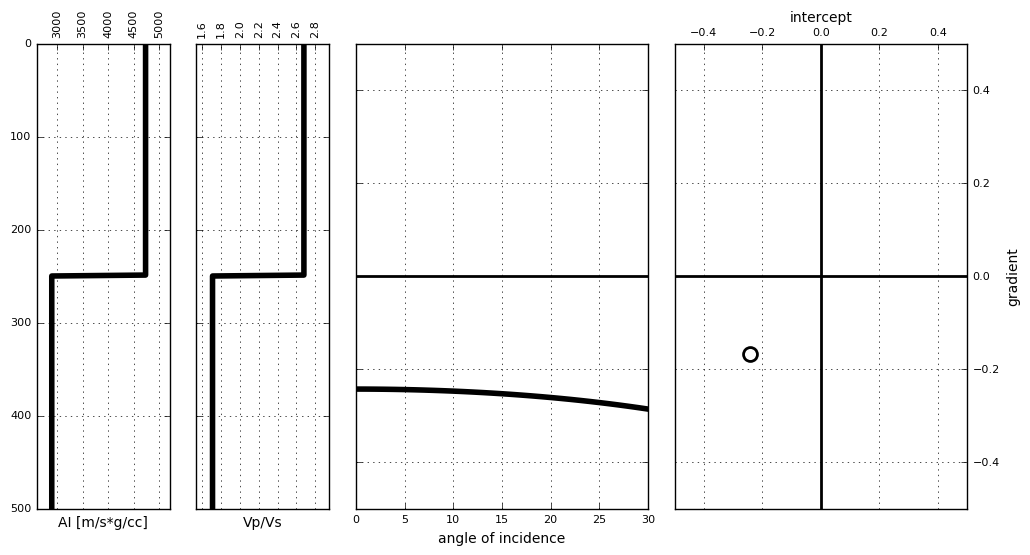

In [10]:
avoplotmod(vp1,vs1,rho1,vp2,vs2,rho2,angmin=0,angmax=30,name=None,polarity='normal',mx=0.5)